In [2]:
import pandas as pd
import sys
import os

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# Add the project root directory to the Python path
# This allows you to import from the 'src' folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import present_value as pv
from src import synthetic_data_generator as sdg


In [3]:
pv = pv.PresentValue()
pv.fetch_salary_increase_per_year()
pv.present_value(1000000, 2015, 2025)

1709387.386259803

In [4]:
def get_head(df: pd.DataFrame) -> pd.DataFrame:
    df_head = df.iloc[ 0:15 , 0:2 ]
    df_head = pd.DataFrame([df_head.iloc[:,1].to_list()], columns=df_head.iloc[:,0].to_list())

    # Assign dtypes: categorical, string, and numeric
    str_cols = [ "NOMBRE DEL PROYECTO"]
    int_cols = [ "AÑO INICIO"]

    df_head[str_cols] = df_head[str_cols].astype("string")
    df_head[int_cols] = df_head[int_cols].astype("Int64")
    
    return df_head.loc[:, ['NOMBRE DEL PROYECTO','AÑO INICIO']]

def get_uf(df: pd.DataFrame) -> pd.DataFrame:
    df_uf = df.iloc[0:11,3:].iloc[ : , :-1 ]
    column_names = (df_uf.iloc[1:, 0].astype(str) + " " + df_uf.iloc[1:, 1].astype(str)).to_list()
    column_names = [column.replace(" nan", "") for column in column_names]
    df_uf = df_uf.drop(df_uf.columns[[1]], axis=1)
    
    return df_uf, column_names

def get_items(df: pd.DataFrame) -> pd.DataFrame:
    
    columns_names_items = [ "1 - TRANSPORTE", "2 - TRAZADO Y DISEÑO GEOMÉTRICO", "2.1 - INFORMACIÓN GEOGRÁFICA", "2.2 TRAZADO Y DISEÑO GEOMÉTRICO", 
                           "2.3 - SEGURIDAD VIAL", "2.4 - SISTEMAS INTELIGENTES", "3 - GEOLOGÍA", "3.1 - GEOLOGÍA", "3.2 - HIDROGEOLOGÍA", 
                           "4 - SUELOS", "5 - TALUDES", "6 - PAVIMENTO", "7 - SOCAVACIÓN", "8 - ESTRUCTURAS", "9 - TÚNELES", "10 - URBANISMO Y PAISAJISMO", 
                           "11 - PREDIAL", "12 - IMPACTO AMBIENTAL", "13 - CANTIDADES", "14 - EVALUACIÓN SOCIOECONÓMICA", "15 - OTROS - MANEJO DE REDES" ]
    
    df_items = df.iloc[ 17:, 0:2 ]
    df_items = pd.DataFrame([df_items.iloc[:,1].to_list()], columns=columns_names_items) 
    return df_items


In [5]:
def assemble_sheet(df: pd.DataFrame) -> pd.DataFrame:

    df_head = get_head(df)
    df_uf, column_names = get_uf(df)
    df_items = get_items(df)
    rows = []
    
    #Create a row for each functional unit
    for i in range(1, df_uf.shape[1]):
        
        #Aggregate longitud, puentes, tuneles for the current functional unit
        df_uf_x = pd.DataFrame([df_uf.iloc[1:,i].to_list()], columns=column_names)  
        df_uf_x['NOMBRE UF'] = df_uf.iloc[0, i]
        
        df_items_for_functional_unit = df_items / 1 # Future consideration divide  by df_uf_totals
        
        row = pd.concat([df_head, df_uf_x, df_items_for_functional_unit], axis=1)
        rows.append(row)
        
    return pd.concat(rows, axis=0, ignore_index=True)


In [6]:
def assemble_project(filename: str) -> pd.DataFrame:
    with pd.ExcelFile(filename, engine="openpyxl") as xls:
        
        project_names = [project_name for project_name in xls.sheet_names if project_name.isnumeric()]
        df_project =[]

        for project_name in project_names:
            df = pd.read_excel(filename, sheet_name=project_name, header=None, engine="openpyxl")
            df_project.append(assemble_sheet(df))
            #TEMPORAL DEBUGGING
            if project_name == '45000036221':
                break 

    return pd.concat(df_project, axis=0, ignore_index=True)



In [7]:
def weighted_values(row: pd.Series) -> pd.Series:

    row = row.fillna(0)

    #Longitude analysis
    longitude_weigth = row['LONGITUD KM WEIGHT']
    row['1 - TRANSPORTE'] *= longitude_weigth
    row['2 - TRAZADO Y DISEÑO GEOMÉTRICO'] *= longitude_weigth
    row['2.1 - INFORMACIÓN GEOGRÁFICA'] *= longitude_weigth
    row['2.2 TRAZADO Y DISEÑO GEOMÉTRICO'] *= longitude_weigth
    row['2.3 - SEGURIDAD VIAL'] *= longitude_weigth
    row['2.4 - SISTEMAS INTELIGENTES'] *= longitude_weigth
    row['3 - GEOLOGÍA'] *= longitude_weigth   
    row['3.1 - GEOLOGÍA'] *= longitude_weigth
    row['3.2 - HIDROGEOLOGÍA'] *= longitude_weigth

    row['5 - TALUDES'] *= longitude_weigth
    row['6 - PAVIMENTO'] *= longitude_weigth
    row['7 - SOCAVACIÓN'] *=     longitude_weigth

    row['11 - PREDIAL'] *= longitude_weigth
    row['12 - IMPACTO AMBIENTAL'] *= longitude_weigth

    row['15 - OTROS - MANEJO DE REDES'] *= longitude_weigth
    
    #Bridge analysis
    bridge_weigth = 1
    if row['PUENTES VEHICULARES UND'] > 0 or row['PUENTES PEATONALES UND'] > 0:
        bridges_ratio = 3
        bridge_weigth = ((row['PUENTES VEHICULARES UND WEIGHT'] + row['PUENTES VEHICULARES M2 WEIGHT'])*bridges_ratio + row['PUENTES PEATONALES UND WEIGHT'])/bridges_ratio*3
        row['4 - SUELOS'] *= bridge_weigth
        row['8 - ESTRUCTURAS'] *= bridge_weigth
    
    #Tunnel analysis
    tunnel_weight = 1
    if row['TUNELES UND'] > 0:
        tunnel_weight = row['TUNELES UND WEIGHT'] + row['TUNELES M2 WEIGHT']
        row['9 - TÚNELES'] *= tunnel_weight
    
    #Urbanism analysis
    urbanism_weight = 1
    if row['PUENTES PEATONALES UND'] > 0:  
        urbanism_weight = row['PUENTES PEATONALES UND WEIGHT']
        row['10 - URBANISMO Y PAISAJISMO'] *= urbanism_weight
    
    return row


In [8]:
def present_value_costs(row: pd.Series, mask: list[str], present_year: int) -> pd.Series:
    for col in mask:
        row[col] = pv.present_value(row[col], row['AÑO INICIO'], present_year) 
    return row

In [9]:
def create_dataset(filename: str) -> pd.DataFrame:
    
    df = assemble_project(filename)

    mask = df.columns[df.columns.str.match(r"^\d")].tolist()
    df_present_value = df.apply(present_value_costs, axis=1, mask=mask, present_year=2025)
    df = df_present_value.drop(columns=['AÑO INICIO', 'NOMBRE UF'])

    cols = df.loc[:, 'LONGITUD KM':'TUNELES M2'].columns
    totals = df.groupby('NOMBRE DEL PROYECTO')[cols].transform('sum').replace(0, pd.NA)
    w = (df[cols] / totals).fillna(0)
    w.columns = [f'{c} WEIGHT' for c in cols]
    df = df.join(w)
    df =df.apply(weighted_values, axis=1)
    df = df.drop(columns=['NOMBRE DEL PROYECTO'])
    df = df.loc[:, 'LONGITUD KM':'15 - OTROS - MANEJO DE REDES']
    return df

In [10]:
def remove_outliers(df, target='2.2 TRAZADO Y DISEÑO GEOMÉTRICO'):
    q1, q3 = df[target].quantile(0.05), df[target].quantile(0.95)
    iqr = q3 - q1
    x_clean = (df[target] >= q1 - 1.5*iqr) & (df[target] <= q3 + 1.5*iqr) & (df[target] != 0)
    
    df_clean = df[x_clean]
    return df_clean

In [11]:
filename = "../data/raw/BASE DE DATOS PRESUPUESTOS.xlsx"
df = create_dataset(filename)

C:\Users\forer\AppData\Local\Temp\ipykernel_24800\3678980944.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = (df[cols] / totals).fillna(0)


In [16]:
df_clean = remove_outliers(df)[['LONGITUD KM', 'ALCANCE', '2.2 TRAZADO Y DISEÑO GEOMÉTRICO']]

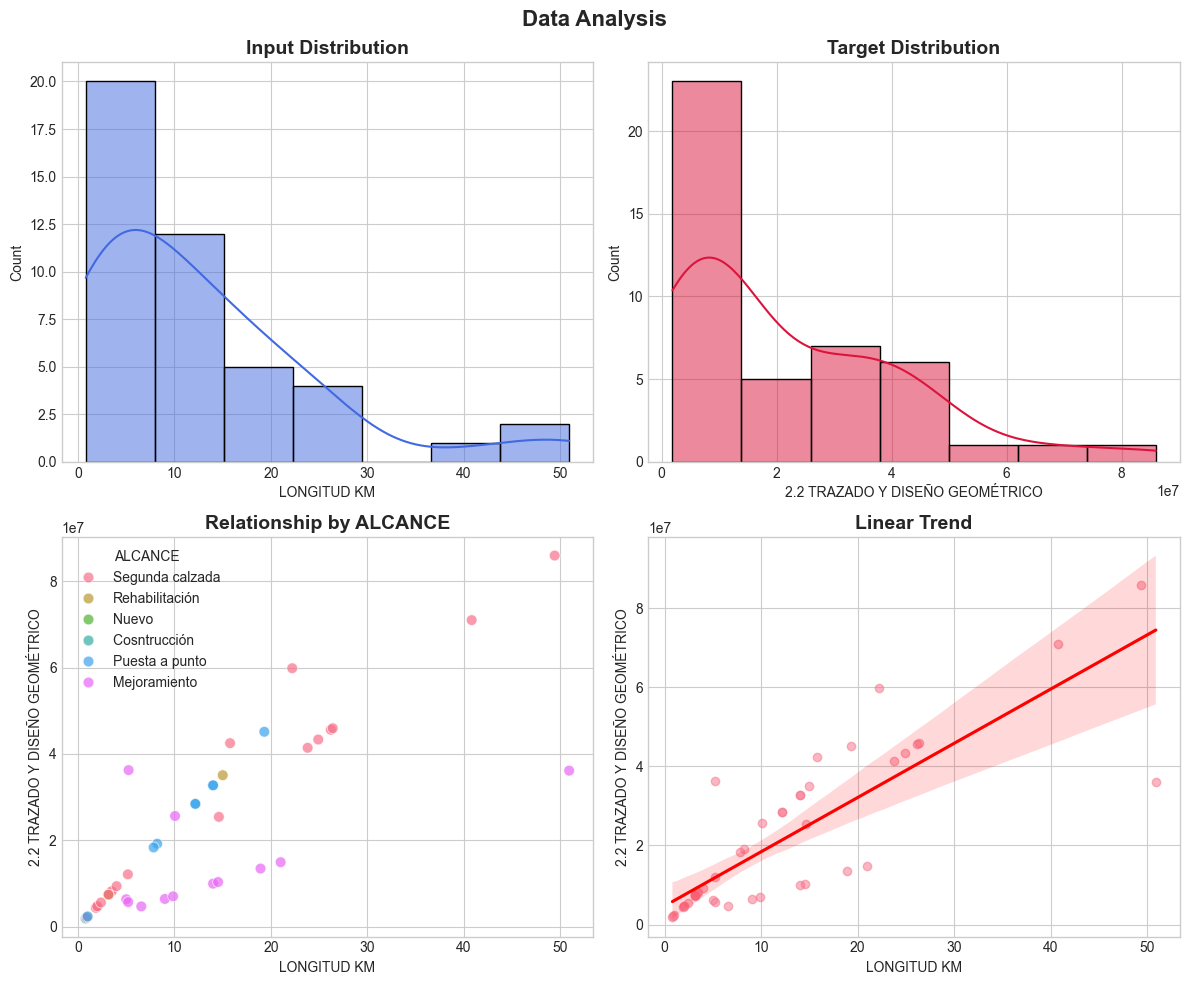

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Input distribution
sns.histplot(df_clean['LONGITUD KM'], kde=True, ax=axes[0,0], color='royalblue')
axes[0,0].set_title('Input Distribution', fontsize=14, weight='bold')

# Output distribution  
sns.histplot(df_clean['2.2 TRAZADO Y DISEÑO GEOMÉTRICO'], kde=True, ax=axes[0,1], color='crimson')
axes[0,1].set_title('Target Distribution', fontsize=14, weight='bold')

# Scatter by category
sns.scatterplot(data=df_clean, x='LONGITUD KM', y='2.2 TRAZADO Y DISEÑO GEOMÉTRICO', 
                hue='ALCANCE', ax=axes[1,0], s=60, alpha=0.7)
axes[1,0].set_title('Relationship by ALCANCE', fontsize=14, weight='bold')

# Joint plot with regression
sns.regplot(data=df_clean, x='LONGITUD KM', y='2.2 TRAZADO Y DISEÑO GEOMÉTRICO', 
            ax=axes[1,1], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[1,1].set_title('Linear Trend', fontsize=14, weight='bold')

plt.suptitle('Data Analysis', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

Best params: {'regressor__svr__C': 100, 'regressor__svr__epsilon': 0.1, 'regressor__svr__gamma': 0.01}
{'Test_R2': 0.956011520332937, 'Test_MAE': 2376545.628492583, 'Test_RMSE': 8854740475084.621, 'Test_MAPE%': 16.37785169688736}


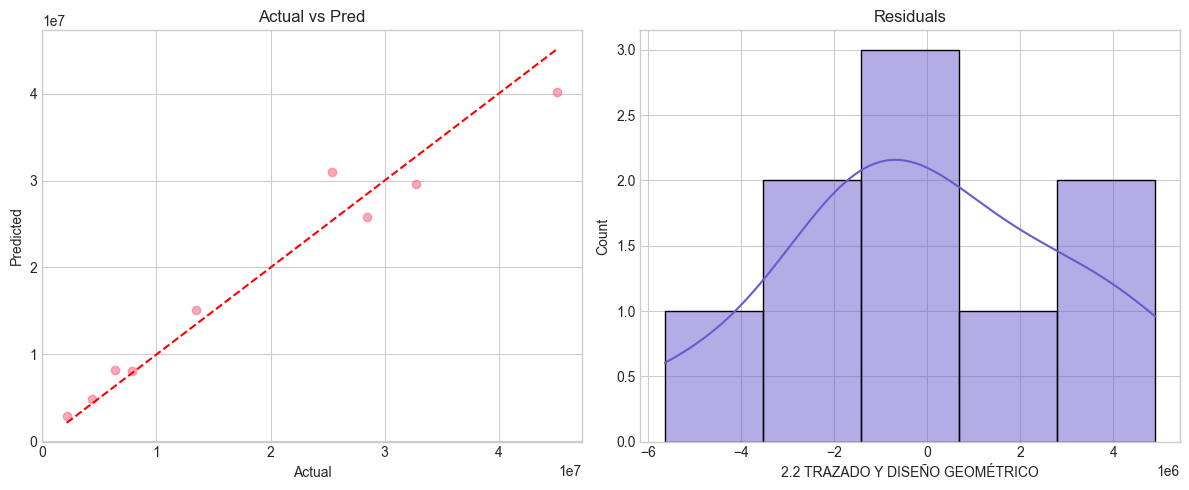

In [39]:

# SVR-only: preprocessing, log-feature, target log-transform, CV + grid search, plots
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

X = df_clean[['LONGITUD KM', 'ALCANCE']].copy()
X['LONGITUD KM LOG'] = np.log1p(X['LONGITUD KM'])
y = df_clean['2.2 TRAZADO Y DISEÑO GEOMÉTRICO'].astype(float)

pre = ColumnTransformer([
    ('num', StandardScaler(), ['LONGITUD KM', 'LONGITUD KM LOG']),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['ALCANCE'])
])

svr = SVR(kernel='rbf')
pipe = Pipeline([('pre', pre), ('svr', svr)])
model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)

param_grid = {
    'regressor__svr__C': [10, 100, 300, 1000],
    'regressor__svr__epsilon': [0.1, 0.3, 0.5, 1.0],
    'regressor__svr__gamma': ['scale', 'auto', 0.1, 0.01],
}

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=1234)
gs = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, refit=True)
gs.fit(Xtr, ytr)

yp = gs.predict(Xte)
mae = mean_absolute_error(yte, yp)
rmse = mean_squared_error(yte, yp)
r2 = r2_score(yte, yp)
mape = np.mean(np.abs((yte - yp) / yte.replace(0, np.nan))) * 100

print('Best params:', gs.best_params_)
print({'Test_R2': r2, 'Test_MAE': mae, 'Test_RMSE': rmse, 'Test_MAPE%': float(mape)})

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].scatter(yte, yp, alpha=0.6); lim = [yte.min(), yte.max()]
ax[0].plot(lim, lim, 'r--'); ax[0].set_title('Actual vs Pred'); ax[0].set_xlabel('Actual'); ax[0].set_ylabel('Predicted')
sns.histplot(yte - yp, kde=True, ax=ax[1], color='slateblue'); ax[1].set_title('Residuals')
plt.tight_layout(); plt.show()

In [40]:
Xte['REAL'] = yte
Xte['PREDICTED'] = yp
Xte

,LONGITUD KM,ALCANCE,LONGITUD KM LOG,REAL,PREDICTED
31,9.00,Mejoramiento,2.302585,6.386797e+06,8.217178e+06
17,1.85,Segunda calzada,1.047319,4.323576e+06,4.854319e+06
35,18.92,Mejoramiento,2.991724,1.342647e+07,1.510034e+07
42,14.60,Segunda calzada,2.747271,2.540472e+07,3.103520e+07
8,19.31,Puesta a punto,3.011113,4.512879e+07,4.022050e+07
13,12.16,Puesta a punto,2.577182,2.841875e+07,2.577442e+07
4,3.37,Segunda calzada,1.474763,7.875920e+06,8.090338e+06
20,14.00,Puesta a punto,2.708050,3.271895e+07,2.960053e+07
10,0.91,Segunda calzada,0.647103,2.126732e+06,2.964701e+06
